# Axisymmetric formulation for elastic structures of revolution {far}`star`

```{admonition} Objectives
:class: objectives

This demo shows how to formulate a linear elastic problem under axisymmetric conditions.
$\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\beps}{\boldsymbol{\varepsilon}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\bT}{\boldsymbol{T}}
\newcommand{\bI}{\boldsymbol{I}}
\newcommand{\T}{^\text{T}}
\newcommand{\tr}{\operatorname{tr}}
\newcommand{\CC}{\mathbb{C}}
\newcommand{\dOm}{\,\text{d}\Omega}
\newcommand{\dom}{\,\text{d}\omega}
\newcommand{\dS}{\,\text{d}S}
\newcommand{\ds}{\,\text{d}s}
\newcommand{\Neumann}{{\partial \Omega_\text{N}}}
\newcommand{\Dirichlet}{{\partial \Omega_\text{D}}}
\newcommand{\neumann}{{\partial \omega_\text{N}}}
\newcommand{\dirichlet}{{\partial \omega_\text{D}}}$
```

```{admonition} Download sources
:class: download

* {Download}`Python script<./axisymmetric_elasticity.py>`
* {Download}`Jupyter notebook<./axisymmetric_elasticity.ipynb>`
```


```{image} axisymmetric_elasticity.png
:align: center
:width: 400px
```

 We will consider a solid of revolution around a fixed axis $(Oz)$, the loading, boundary conditions and material properties being also invariant with respect to a rotation along the symmetry axis. The solid cross-section in a plane $\theta=\text{cst}$ will be represented by a two-dimensional domain $\omega$. With such a 2D mesh, the first spatial variable (`x[0]` in `UFL`) will represent the radial coordinate $r$ whereas the second spatial variable (`x[1]`) will denote the axial variable $z$.

## Problem position

We will investigate here the case of a hollow hemisphere of inner (resp. outer) radius $R_i$ (resp. $R_e$). We impose an external pressure on the outer radius boundary. Due to the revolution symmetry, the 2D cross-section corresponds to a quarter of a hollow cylinder.

We first import the relevant modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gmsh
from mpi4py import MPI
import ufl
from dolfinx import mesh, fem, io
import dolfinx.fem.petsc

hsize = 0.2

Re = 11.0
Ri = 9.0

The domain is created and meshed using the `Gmsh` Python API.

In [2]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)  # to disable meshing info
gdim = 2
model_rank = 0
gmsh.model.add("Model")

geom = gmsh.model.geo
center = geom.add_point(0, 0, 0)
p1 = geom.add_point(Ri, 0, 0)
p2 = geom.add_point(Re, 0, 0)
p3 = geom.add_point(0, Re, 0)
p4 = geom.add_point(0, Ri, 0)

x_radius = geom.add_line(p1, p2)
outer_circ = geom.add_circle_arc(p2, center, p3)
y_radius = geom.add_line(p3, p4)
inner_circ = geom.add_circle_arc(p4, center, p1)

boundary = geom.add_curve_loop([x_radius, outer_circ, y_radius, inner_circ])
surf = geom.add_plane_surface([boundary])

geom.synchronize()

gmsh.option.setNumber("Mesh.CharacteristicLengthMin", hsize)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", hsize)

gmsh.model.addPhysicalGroup(gdim, [surf], 1)
gmsh.model.addPhysicalGroup(gdim - 1, [x_radius], 1, name="bottom")
gmsh.model.addPhysicalGroup(gdim - 1, [y_radius], 2, name="left")
gmsh.model.addPhysicalGroup(gdim - 1, [outer_circ], 3, name="outer")


gmsh.model.mesh.generate(gdim)

domain, _, facets = io.gmshio.model_to_mesh(
    gmsh.model, MPI.COMM_WORLD, model_rank, gdim=gdim
)
gmsh.finalize()

## Definition of axisymmetric strains and stresses

For axisymmetric conditions, the unknown displacement field is of the form:

$$
\boldsymbol{u} = u_r(r,z)\boldsymbol{e}_r + u_z(r,z)\boldsymbol{e}_z
$$

As a result, we will work with a standard vectorial function space of dimension 2 for discretizing $u_r$ and $u_z$ respectively. The associated strain components are however given by:

$$
\boldsymbol{\varepsilon} = \begin{bmatrix} \partial_r u_r & 0 & (\partial_z u_r + \partial_r u_z)/2 \\
0 & u_r/r & 0 \\
(\partial_z u_r + \partial_r u_z)/2 & 0 & \partial_z u_z\end{bmatrix}_{(\boldsymbol{e}_r,\boldsymbol{e}_\theta,\boldsymbol{e}_z)}
$$

The previous relation involves explicitly the radial variable $r$, which can be obtained from the `ufl.SpatialCoordinate` `x[0]`, the strain-displacement relation is then defined explicitly in the `eps` function.

```{note}
We could also express the strain components in the form of a vector of size 4 in alternative of the 3D tensor representation implemented below.
```

In [3]:
x = ufl.SpatialCoordinate(domain)


def eps(v):
    return ufl.sym(
        ufl.as_tensor(
            [
                [v[0].dx(0), 0, v[0].dx(1)],
                [0, v[0] / x[0], 0],
                [v[1].dx(0), 0, v[1].dx(1)],
            ]
        )
    )

The linear elastic constitutive equation giving the stress `sigma` is written using 3D tensors:

In [4]:
E = fem.Constant(domain, 1e5)
nu = fem.Constant(domain, 0.3)
mu = E / 2 / (1 + nu)
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)


def sigma(v):
    return lmbda * ufl.tr(eps(v)) * ufl.Identity(3) + 2.0 * mu * eps(v)

## Weak formulation

The rest of the formulation is similar to the 2D elastic case with a small difference in the integration measure. Indeed, the virtual work principle reads as:

$$
 \text{Find } \boldsymbol{u}\in V \text{ s.t. } \int_{\Omega}
 \boldsymbol{\sigma}(\boldsymbol{u}):\boldsymbol{\varepsilon}(\boldsymbol{v}) \dOm
 = \int_{\Neumann} \boldsymbol{T}\cdot\boldsymbol{v} \dS \quad \forall\boldsymbol{v} \in V
 $$

where $\boldsymbol{T}$ is the imposed traction on some part $\Neumann$ of the domain boundary.

In axisymmetric conditions, the full 3D domain $\Omega$ can be decomposed as $\Omega = \omega \times [0;2\pi]$ where the interval represents the $\theta$ variable. The integration measures therefore reduce to $\dOm = \dom\cdot(r\,\text{d}\theta)$ and $\dS = \ds\cdot(r\,\text{d}\theta)$ where $dS$ is the surface integration measure on the 3D domain $\Omega$ and $ds$ its counterpart on the cross-section boundary $\partial \omega$. Exploiting the invariance of all fields with respect to $\theta$, the previous virtual work principle is reformulated on the cross-section only as follows:

$$
 \text{Find } \boldsymbol{u}\in V \text{ s.t. } \int_{\omega}
 \boldsymbol{\sigma}(\boldsymbol{u}):\boldsymbol{\varepsilon}(\boldsymbol{v}) r \dom
 = \int_{\neumann} \boldsymbol{T}\cdot\boldsymbol{v}  r\ds \quad \forall\boldsymbol{v} \in V
 $$

where the $2\pi$ constants arising from the integration on $\theta$ have been cancelled on both sides. As a result, the bilinear and linear form are similar to the plane 2D case with the exception of the additional $r$ term in the integration measures.

```{warning}
Some terms in the integrand, e.g. the strain $\beps$, contain terms exhibiting a $\dfrac{1}{r}$ singularity at $r=0$. In practice, there should not be any issue regarding such a singularity since integrals are evaluated approximately using quadrature rules. Integrands are then evaluated at quadrature points which usually lie inside strictly inside the element (default scheme). For non-classical quadrature, such as vertex schemes or GLL points, you may have some trouble with such singular terms.
```

## Resolution

The final formulation is therefore pretty straightforward. Since a uniform pressure loading is applied on the outer boundary, we will also need the exterior normal vector to define the work of external forces form.

In [5]:
ds = ufl.Measure("ds", domain=domain, subdomain_data=facets)
dx = ufl.Measure("dx", domain=domain)

n = ufl.FacetNormal(domain)
p = fem.Constant(domain, 10.0)

V = fem.functionspace(domain, ("P", 2, (gdim,)))
du = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)
a_form = ufl.inner(sigma(du), eps(u_)) * x[0] * dx
L_form = ufl.inner(-p * n, u_) * x[0] * ds(3)

u = fem.Function(V, name="Displacement")

We apply smooth contact conditions on the vertical $r=0$ (facet tag `2`) and the horizontal $z=0$ (facet tag `1`) boundaries.

In [6]:
Vx, _ = V.sub(0).collapse()
Vy, _ = V.sub(1).collapse()
bottom_dofsy = fem.locate_dofs_topological((V.sub(1), Vy), gdim - 1, facets.find(1))
top_dofsx = fem.locate_dofs_topological((V.sub(0), Vx), gdim - 1, facets.find(2))

# used for post-processing
bottom_dofsx = fem.locate_dofs_topological((V.sub(0), Vx), gdim - 1, facets.find(1))[1]

u0x = fem.Function(Vx)
u0y = fem.Function(Vy)
bcs = [
    fem.dirichletbc(u0x, top_dofsx, V.sub(0)),
    fem.dirichletbc(u0y, bottom_dofsy, V.sub(1)),
]

# solve problem
problem = fem.petsc.LinearProblem(a_form, L_form, u=u, bcs=bcs)
problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0), blocked element (Basix element (P, triangle, 2, gll_warped, unset, False, float64, []), (2,))), 0)

For this specific case, we can compare to the classical solution of a hollow sphere under external pressure with a purely radial displacement given by:

$$
u_r(r) = -\dfrac{R_e^3}{R_e^3-R_i^3}\left((1 − 2\nu)r + (1 + \nu)\dfrac{R_i^3}{2r^2}\right)\dfrac{p}{E},
\quad u_z=0
$$

We extract the radial displacement dofs on the bottom boundary and compare with the analytical solution.

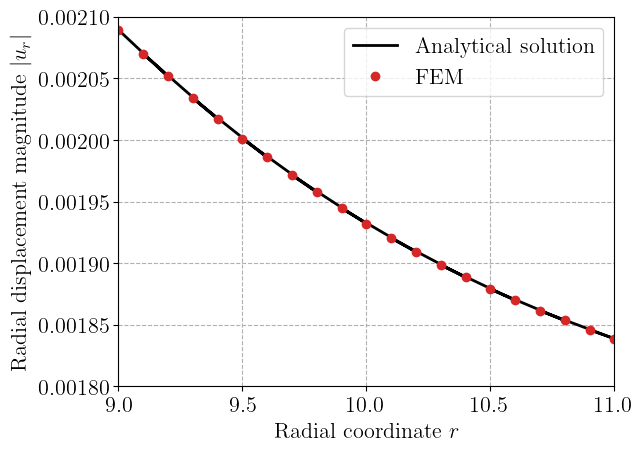

In [7]:
ur = u.sub(0).collapse()
ur_FEM = ur.vector.array[bottom_dofsx]

r = Vx.tabulate_dof_coordinates()[bottom_dofsx, 0]

nu0 = nu.value
ur_theo = -(
    Re**3
    / (Re**3 - Ri**3)
    * float(p / E)
    * ((1 - 2 * nu0) * r + (1 + nu0) * Ri**3 / 2 / r**2)
)


plt.plot(r, np.abs(ur_theo), "-k", label="Analytical solution")
plt.plot(r, np.abs(ur_FEM), "oC3", label="FEM")
plt.xlabel("Radial coordinate $r$")
plt.ylabel("Radial displacement magnitude $|u_r|$")
plt.legend()
plt.show()